# Sounding parameters analysis with regards to Skew T

Import all needed libraries for analysis. Matplotlib, pandas and numpy are used for standard data analysis. Urllib and bs4 used for data collection or web scrapping. Siphon is used from Unidata's Library for faster and simpler sounding data collection in pandas format.

In [1]:
from siphon.simplewebservice.wyoming import WyomingUpperAir
from datetime import datetime
import matplotlib.pyplot as plt
from pylab import rcParams
import urllib.request
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np
import math

Enter desired date and station number (ID). Data is acquired from Wyoming University Website (http://weather.uwyo.edu/upperair/sounding.html). For more details on available stations, further research on website is recommended. Data for Zagreb is used here (LDDD or 14240) and turbulent stormy day was chosen. Day, month and year data is available for atleast last ten years. Since the soundings are launched only at 0 and 12 UTC, those are only possible numbers for hours. Note: Mistakes are possible, especially regarding comlete sounding data wich could be missing for some days/hours.

In [2]:
date = datetime(2019,7,7,12)
station = 'LDDD'

Getting data into pandas Dataframe using Siphon Library. Adjusting size for plots. Data used for this analysis (df1) can be seen in table on this link (first table): http://weather.uwyo.edu/cgi-bin/sounding?region=europe&TYPE=TEXT%3ALIST&YEAR=2019&MONTH=07&FROM=0712&TO=0712&STNM=LDDD. 

In [3]:
df1 = WyomingUpperAir.request_data(date,station)

rcParams['figure.figsize'] = 16, 10

Scrapping data from the same website. Since Siphon only fetches data from sounding, various indices and parameters (same link from above, data under 'Station information and sounding indices') must be scrapped, cleaned and stored manually.

In [6]:
Year = date.year
Month = date.month
Day = date.day
Hour = date.hour

if (date.hour == 0):
    url = 'http://weather.uwyo.edu/cgi-bin/sounding?region=europe&TYPE=TEXT%3ALIST&YEAR={Year}&MONTH=0{Month}&FROM=0{Day}0{Hour}&TO=0{Day}0{Hour}&STNM={Station}'.format(Year = Year, Month = Month, Day = Day, Hour = Hour, Station = station)
else:
    url = 'http://weather.uwyo.edu/cgi-bin/sounding?region=europe&TYPE=TEXT%3ALIST&YEAR={Year}&MONTH=0{Month}&FROM=0{Day}{Hour}&TO=0{Day}{Hour}&STNM={Station}'.format(Year = Year, Month = Month, Day = Day, Hour = Hour, Station = station)

response = urllib.request.urlopen(url)
html = response.read()

soup = BeautifulSoup(html,features="lxml")
data = soup.find_all('pre')

Sound_data = str(data[1])

x = re.findall(r'[-+]?[.]?[\d].+', Sound_data)

x1 = []

i = 0
for i in range(0, len(x)):
    if (i != 1 and 'thickness' not in x[i]):
        x[i] = float(x[i])
        x1.append(x[i])
    i = i + 1
    
y = ['Station number', 'Station latitude', 'Station longitude', 'Station elevation', \
     'Showalter index', 'Lifted index', 'LIFT computed using virtual temperature', 'SWEAT index', 'K index', \
     'Cross totals index', 'Vertical totals index', 'Totals totals index', 'Convective Available Potential Energy', \
     'CAPE using virtual temperature', 'Convective Inhibition', 'CINS using virtual temperature', 'Equilibrum Level', \
     'Equilibrum Level using virtual temperature', 'Level of Free Convection', 'LFCT using virtual temperature', \
     'Bulk Richardson Number', 'Bulk Richardson Number using CAPV', 'Temp [K] of the Lifted Condensation Level', \
     'Pres [hPa] of the Lifted Condensation Level', 'Mean mixed layer potential temperature', \
     'Mean mixed layer mixing ratio', 'Precipitable water [mm] for entire sounding']

y1 = []

j = 0
for j in range(0, len(y)):
    if (y[j] in Sound_data):
        y1.append(y[j])
    j = j + 1
    
all_data = {'Parameter': y1, 'Value': x1}
df2 = pd.DataFrame(data = all_data)


If wanted, data can be seen here:

In [7]:
print(df1)
print(df2)

     pressure  height  temperature  dewpoint  direction  speed     u_wind  \
0       993.0     246         30.6      15.6      290.0    2.0   1.879385   
1       992.0     253         28.6      16.6      288.0    2.0   1.902113   
2       925.0     747         23.0      14.0      165.0    4.0  -1.035276   
3       853.0    1447         16.4      13.0      223.0    2.0   1.363997   
4       850.0    1477         16.6      12.5      225.0    2.0   1.414214   
5       823.0    1751         14.7      12.7      225.0   10.0   7.071068   
6       803.0    1960         13.2      12.8      240.0   10.0   8.660254   
7       789.0    2108         12.4      10.9      250.0   10.0   9.396926   
8       767.0    2346         11.0       7.9      249.0   12.0  11.202965   
9       700.0    3103          5.6       3.9      245.0   19.0  17.219848   
10      690.0    3221          4.7       3.1      240.0   21.0  18.186533   
11      684.0    3292          4.2       2.7      242.0   22.0  19.424847   

Now, when our data is ready, comes the fun part. 

Expected weather type is divided in four categories regarding their strength and attributes when present. Each type gets or loses points if certain conditions are met. When all points are added for each type, at the end of calculation points are divided by maximum possible points for each type of weather. In that way we get percentage of realization which can then be divided into four groups (low chance,likely,high chance). For starters, all are initialised to zero.

Categories:

1. No storms - Low chance for any kind of storm, including showers. Regardless of that, weather can still be cloudy or even rainy (snowy).

2. Thunderstorms - Weak convective process with showers and probably some thunder. Small hail and stronger wind gusts possible if certain conditions are met (rarely).

3. Severe storms - Medium to strong convective processes with (heavy) showers, thunderstorms, strong wind gusts, (bigger) hail. 

4. Supercells - (Very) strong convective processes with possible extremly heavy rain, big hail, very high wind and even tornado. 


In [8]:
no_storms = 0
weak_storms = 0
moderate_storms = 0
strong_storms = 0
supercells = 0



1. Lifted index

In [9]:
LI = int(df2[df2['Parameter']=='LIFT computed using virtual temperature'].index.values.astype(int)[0])

if (df2.iloc[LI]['Value'] < -6):
    strong_storms = strong_storms + 2
    moderate_storms = moderate_storms + 2
        
elif (df2.iloc[LI]['Value'] < -3 and df2.iloc[LI]['Value'] >= -6):
    strong_storms = strong_storms + 1
    moderate_storms = moderate_storms + 1
    
elif (df2.iloc[LI]['Value'] < 0 and df2.iloc[LI]['Value'] >= -3):
    moderate_storms = moderate_storms + 1

else:
    strong_storms = strong_storms - 1
    moderate_storms = moderate_storms - 1
    no_storms = no_storms + 1



2. SWEAT Index

In [10]:
sweat = int(df2[df2['Parameter']=='SWEAT index'].index.values.astype(int)[0])

if (df2.iloc[sweat]['Value'] >= 400):
    supercells = supercells + 2
    strong_storms = strong_storms + 3
elif (df2.iloc[sweat]['Value'] >= 300 and df2.iloc[sweat]['Value'] < 400):
    supercells = supercells + 1
    strong_storms = strong_storms + 2
elif (df2.iloc[sweat]['Value'] >= 150 and df2.iloc[sweat]['Value'] < 300):
    strong_storms = strong_storms + 1
else:
    supercells = supercells - 1
    strong_storms = strong_storms - 1

3. K Index

In [11]:
KI = int(df2[df2['Parameter']=='K index'].index.values.astype(int)[0])
    
if (df2.iloc[KI]['Value'] >= 40):
    strong_storms = strong_storms + 2
    moderate_storms = moderate_storms + 2
elif (df2.iloc[KI]['Value'] >= 20 and df2.iloc[KI]['Value'] < 40):
    strong_storms = strong_storms + 1
    moderate_storms = moderate_storms + 1
else:
    strong_storms = strong_storms - 1
    moderate_storms = moderate_storms - 1
    no_storms = no_storms + 1

4. TT Index

In [12]:
TT = int(df2[df2['Parameter']=='Totals totals index'].index.values.astype(int)[0])
    
if (df2.iloc[TT]['Value'] >= 53):
    supercells = supercells + 2
    strong_storms = strong_storms + 2
elif (df2.iloc[TT]['Value'] >= 51 and df2.iloc[TT]['Value'] < 53):
    supercells = supercells + 1
    strong_storms = strong_storms + 1
    moderate_storms = moderate_storms + 1
elif (df2.iloc[TT]['Value'] >= 44 and df2.iloc[TT]['Value'] < 50):
    supercells = supercells - 1
    strong_storms = strong_storms - 1
    moderate_storms = moderate_storms + 1
else:
    supercells = supercells - 2
    strong_storms = strong_storms - 2
    moderate_storms = moderate_storms - 1
    no_storms = no_storms + 1  


5. CAPE and Shear 0-6 km

In [13]:
CAPE = int(df2[df2['Parameter']=='CAPE using virtual temperature'].index.values.astype(int)[0])

six = int(df1[df1['height'] >= 6000].index[0])
kut_0km = df1['direction'].iloc[0]
kut_6km = df1['direction'].iloc[six]
brzina_0km_x = df1['speed'].iloc[0] * math.cos(math.radians(-kut_0km+90))
brzina_0km_y = df1['speed'].iloc[0] * math.sin(math.radians(-kut_0km+90))
brzina_6km_x = df1['speed'].iloc[six] * math.cos(math.radians(-kut_6km+90))
brzina_6km_y = df1['speed'].iloc[six] * math.sin(math.radians(-kut_6km+90))
shear = 0.514*(math.sqrt((brzina_6km_x-brzina_0km_x)**2+(brzina_6km_y-brzina_0km_y)**2))

if (df2.iloc[CAPE]['Value'] >= 2000):
    if (shear >= 20):
        supercells = supercells + 7
        strong_storms = strong_storms + 7
    elif (shear >= 15 and shear < 20):
        supercells = supercells + 6
        strong_storms = strong_storms + 6
    elif (shear >= 10 and shear < 15):
        supercells = supercells + 3
        strong_storms = strong_storms + 5
    else:
        strong_storms = strong_storms + 3
        supercells = supercells - 3
    moderate_storms = moderate_storms + 1
    
elif (df2.iloc[CAPE]['Value'] >= 1500 and df2.iloc[CAPE]['Value'] < 2000):
    if (shear >= 20):
        supercells = supercells + 6
        strong_storms = strong_storms + 6
    elif (shear >= 14.9 and shear < 20):
        supercells = supercells + 5
        strong_storms = strong_storms + 5
    elif (shear >= 10 and shear < 14.9):
        supercells = supercells + 3
        strong_storms = strong_storms + 4
    else:
        strong_storms = strong_storms + 2
        supercells = supercells - 3
    moderate_storms = moderate_storms + 1
    
elif (df2.iloc[CAPE]['Value'] >= 1000 and df2.iloc[CAPE]['Value'] < 1500):
    if (shear >= 20):
        supercells = supercells + 5
        strong_storms = strong_storms + 5
    elif (shear >= 15 and shear <= 20):
        supercells = supercells + 4
        strong_storms = strong_storms + 4
    elif (shear >= 10 and shear <= 15):
        supercells = supercells + 2
        strong_storms = strong_storms + 3
    else:
        strong_storms = strong_storms + 1
        supercells = supercells - 3
    moderate_storms = moderate_storms + 1
    
elif (df2.iloc[CAPE]['Value'] >= 500 and df2.iloc[CAPE]['Value'] < 1000):
    if (shear >= 20):
        supercells = supercells + 4
        strong_storms = strong_storms + 4
    elif (shear >= 15 and shear <= 20):
        supercells = supercells + 3
        strong_storms = strong_storms + 3
    elif (shear >= 10 and shear <= 15):
        strong_storms = strong_storms + 2
        supercells = supercells - 1
    else:
        strong_storms = strong_storms - 1
        supercells = supercells - 3
    moderate_storms = moderate_storms + 1
    
elif (df2.iloc[CAPE]['Value'] >= 70 and df2.iloc[CAPE]['Value'] < 500):
    if (shear >= 20):
        supercells = supercells + 3
        strong_storms = strong_storms + 3
        moderate_storms = moderate_storms + 2
    elif (shear >= 15 and shear <= 20):
        strong_storms = strong_storms + 2
        supercells = supercells - 1
        moderate_storms = moderate_storms + 2
    elif (shear >= 10 and shear <= 15):
        moderate_storms = moderate_storms + 1
        supercells = supercells - 3
    else:
        strong_storms = strong_storms - 1
        supercells = supercells - 4
        no_storms = no_storms + 1
        
elif (df2.iloc[CAPE]['Value'] < 70):
    if (shear >= 20):
        strong_storms = strong_storms + 2
        moderate_storms = moderate_storms + 2
    elif (shear >= 15 and shear <= 20):
        supercells = supercells - 1
        moderate_storms = moderate_storms + 1
    else:
        supercells = supercells - 3
        strong_storms = strong_storms - 2
        no_storms = no_storms + 1

6. CIN

In [14]:
CIN = int(df2[df2['Parameter']=='CINS using virtual temperature'].index.values.astype(int)[0])
    
if (df2.iloc[CIN]['Value'] <= -130 and df2.iloc[CAPE]['Value'] < 500):
    supercells = supercells - 3
    strong_storms = strong_storms - 3
    moderate_storms = moderate_storms - 3
    no_storms = no_storms + 3
elif (df2.iloc[CIN]['Value'] <= -130 and df2.iloc[CAPE]['Value'] > 500):
    supercells = supercells - 2
    strong_storms = strong_storms - 2
    moderate_storms = moderate_storms - 2
    no_storms = no_storms + 2
elif (df2.iloc[CIN]['Value'] <= -50 and df2.iloc[CIN]['Value'] > -130 and df2.iloc[CAPE]['Value'] < 200):
    supercells = supercells - 3
    strong_storms = strong_storms - 3
    moderate_storms = moderate_storms - 3
    no_storms = no_storms + 3
elif (df2.iloc[CIN]['Value'] <= -50 and df2.iloc[CIN]['Value'] > -130 and df2.iloc[CAPE]['Value'] > 200):
    supercells = supercells - 2
    strong_storms = strong_storms - 2
    moderate_storms = moderate_storms - 2
    no_storms = no_storms + 2
elif (df2.iloc[CIN]['Value'] > -50 and df2.iloc[CAPE]['Value'] < 90):
    supercells = supercells - 3
    strong_storms = strong_storms - 3
    moderate_storms = moderate_storms - 3
    no_storms = no_storms + 3
elif (df2.iloc[CIN]['Value'] > -50 and df2.iloc[CAPE]['Value'] > 90 and df2.iloc[CAPE]['Value'] < 500):
    supercells = supercells - 1
    moderate_storms = moderate_storms + 1
else:
    supercells = supercells + 1
    strong_storms = strong_storms + 1
    moderate_storms = moderate_storms + 1

7. Level of Free Convection

In [15]:
LFCT = int(df2[df2['Parameter']=='LFCT using virtual temperature'].index.values.astype(int)[0])

pom = int(df1[df1['pressure'] <= df2.iloc[LFCT]['Value']].index[0])
LFCT_level = df1['height'].iloc[pom]

if (LFCT_level < 3150 and (moderate_storms >= 4 or strong_storms >= 6 or supercells >= 3)):
    moderate_storms = moderate_storms + 1
    strong_storms = strong_storms + 1
    supercells = supercells + 1

No storms sign - add more points to that category.

In [16]:
if (moderate_storms <= 3 and strong_storms <= 0 and supercells <= 0):
    no_storms = no_storms + 2

Determine percentage chance for each category by dividing its number of points with maximum available points.

In [17]:
x = ['No storms', 'Thunderstorms', 'Severe storms', 'Supercells']
index = np.arange(len(x))     
y = [no_storms/9*100, moderate_storms/9*100, strong_storms/18*100, supercells/13*100]
for j in range(0, len(y)):
    if (y[j] < 0):
        y[j] = 0

Plot data:

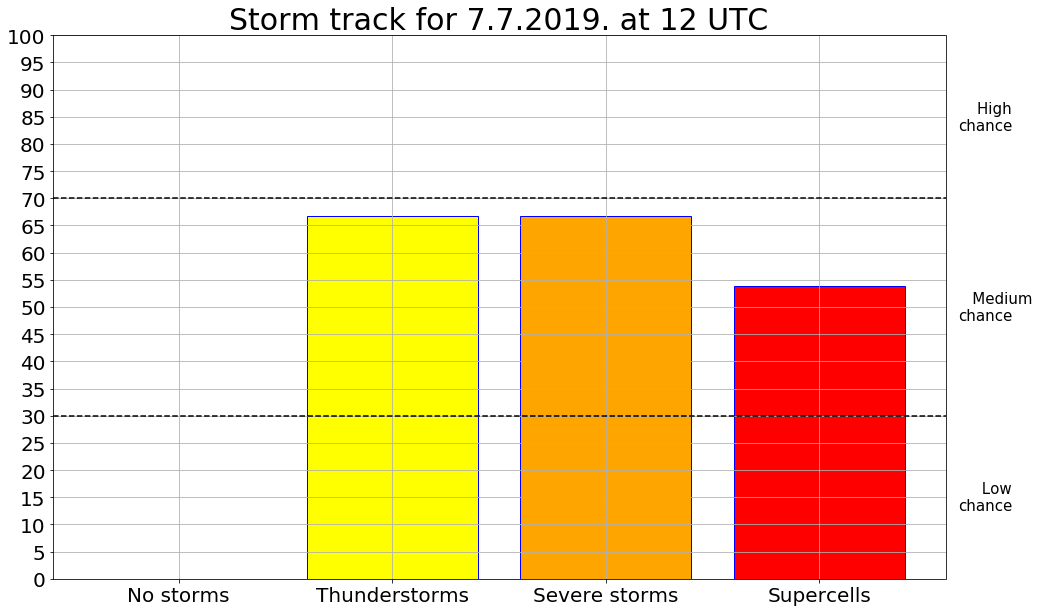

In [19]:
plt.bar(index, y, align='center', color=['green', 'yellow', 'orange', 'red'],  edgecolor='blue')
plt.xticks(index, x, fontsize = 20)
plt.yticks(np.arange(0, 105, 5), fontsize = 20)
plt.axhline(30, color="black", linestyle='dashed')
plt.text(3.65, 15, "     Low \nchance", va='center', ha="left",  fontsize = 15)
plt.axhline(70, color="black", linestyle='dashed')
plt.text(3.65, 50, "   Medium \nchance", va='center', ha="left", fontsize = 15)
plt.text(3.65, 85, "    High \nchance", va='center', ha="left", fontsize = 15)
a = 'Storm track for {day}.{month}.{year}. at {hour} UTC'.format(day = date.day, month = date.month, year = date.year, hour = date.hour)
plt.title(a, fontsize = 30)
plt.grid()

Results are pretty good, sounding area had very unstable afternoon that day. 

Skew T can be seen here:

http://weather.uwyo.edu/cgi-bin/sounding?region=europe&TYPE=GIF%3ASKEWT&YEAR=2019&MONTH=07&FROM=0712&TO=0712&STNM=LDDD